# Packages

In [7]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from scipy.stats import norm

# Helper functions

In [ ]:
# ----- Black-Scholes path simulator -----
def simulate_paths(model="BS", N_paths=5000, N_steps=30, S0=100, mu=0, sigma=0.2, dt=None):
    if dt is None:
        dt = 1.0 / N_steps
    S_paths = np.zeros((N_paths, N_steps + 1))
    S_paths[:, 0] = S0
    for t in range(1, N_steps + 1):
        z = np.random.randn(N_paths)
        S_paths[:, t] = S_paths[:, t-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z)
    return S_paths

# ----- Black-Scholes Delta -----
def bs_call_delta(S, K, T, r, sigma):
    """
    Vectorized Black-Scholes delta for a European call option.
    S: [n_paths, n_steps] spot prices
    K: strike (scalar)
    T: [n_steps] time to maturity for each step (in years)
    r: risk-free rate (scalar)
    sigma: volatility (scalar)
    Returns:
        delta: [n_paths, n_steps] delta for each path and step
    """
    # Avoid division by zero at T=0
    T = np.maximum(T, 1e-8)
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    return norm.cdf(d1)


# ----- LSTM network for hedging -----
class HedgingLSTM(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=32, n_layers=3):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out)

# ----- Batched P&L calculation in torch -----
def compute_pnl_torch(S_batch, deltas, transaction_cost=0.01, strike=100):
    batch_size, seq_len, _ = S_batch.shape
    cash = torch.zeros(batch_size, device=S_batch.device)
    delta_prev = torch.zeros(batch_size, device=S_batch.device)
    for k in range(seq_len):
        delta_k = deltas[:, k, 0]
        S_k = S_batch[:, k, 0]
        trade = delta_k - delta_prev
        cost = transaction_cost * torch.abs(trade) * S_k
        cash = cash - trade * S_k - cost
        delta_prev = delta_k
    payoff = torch.relu(S_batch[:, -1, 0] - strike)
    pnl = cash + delta_prev * S_batch[:, -1, 0] - payoff
    return pnl

'''# 3. Compute hedging P&L with transaction costs
def compute_pnl(S_path, NN, transaction_cost):
    n = len(S_path)
    deltas = []
    cash = 0
    delta_prev = 0
    for k in range(n):
        # Option 1: Use only S_{t_k}
        #delta_k = NN(S_path[k])
        # Option 2: Use RNN, so 
        delta_k = NN(S_path[:k+1])
        deltas.append(delta_k)
        # Trading cost
        trade = delta_k - delta_prev
        cost = transaction_cost * abs(trade) * S_path[k]
        cash -= trade * S_path[k] + cost
        delta_prev = delta_k
    # Terminal P&L: unwind all, pay option payoff
    payoff = max(S_path[-1] - strike, 0)
    pnl = cash + delta_prev * S_path[-1] - payoff
    return pnl
'''

# ----- Loss for neural network ------
def expected_shortfall(losses, q):
    # losses: 1D torch tensor
    sorted_losses, _ = torch.sort(losses)
    n = len(losses)
    idx = max(1, int((1 - q) * n))
    return sorted_losses[:idx].mean()

def mixed_expected_shortfall(losses, alpha=0.95, beta=0.05):
    es_50 = expected_shortfall(losses, 0.5)
    es_alpha = expected_shortfall(losses, alpha)
    return (es_50 + beta * es_alpha) / (1 + beta)



# Parameters

Epoch 0, MixedES Loss: -0.01
Epoch 1, MixedES Loss: -0.02
Epoch 2, MixedES Loss: -0.05
Epoch 3, MixedES Loss: -0.16
Epoch 4, MixedES Loss: -0.32
Epoch 5, MixedES Loss: -0.42
Epoch 6, MixedES Loss: -0.50
Epoch 7, MixedES Loss: -0.56
Epoch 8, MixedES Loss: -0.60
Epoch 9, MixedES Loss: -0.66
Epoch 10, MixedES Loss: -0.68
Epoch 11, MixedES Loss: -0.71
Epoch 12, MixedES Loss: -0.75
Epoch 13, MixedES Loss: -0.74
Epoch 14, MixedES Loss: -0.76
Epoch 15, MixedES Loss: -0.76
Epoch 16, MixedES Loss: -0.75
Epoch 17, MixedES Loss: -0.77
Epoch 18, MixedES Loss: -0.75
Epoch 19, MixedES Loss: -0.77
Epoch 20, MixedES Loss: -0.78
Epoch 21, MixedES Loss: -0.77
Epoch 22, MixedES Loss: -0.76
Epoch 23, MixedES Loss: -0.78
Epoch 24, MixedES Loss: -0.77
Epoch 25, MixedES Loss: -0.77
Epoch 26, MixedES Loss: -0.78
Epoch 27, MixedES Loss: -0.76
Epoch 28, MixedES Loss: -0.78
Epoch 29, MixedES Loss: -0.78
Epoch 30, MixedES Loss: -0.78
Epoch 31, MixedES Loss: -0.78
Epoch 32, MixedES Loss: -0.78
Epoch 33, MixedES Lo

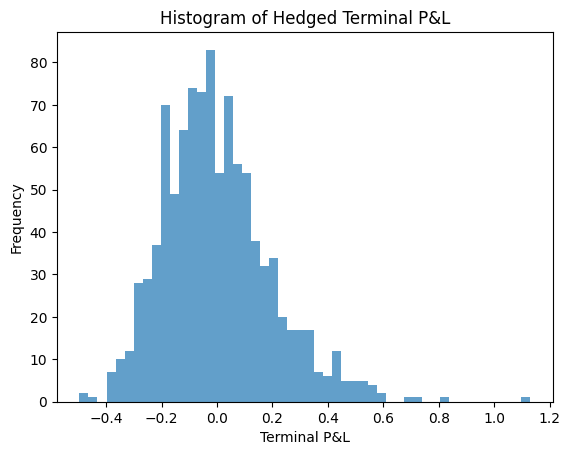

In [ ]:
# Parameters
N_paths = 5000
N_steps = 30
batch_size = 128
transaction_cost = 0.0
strike = 100
S0 = 100
hidden_dim = 32
lr = 1e-4
n_epochs = 50
alpha = 0.95
beta = 0.05


# Data generation

In [ ]:
# Data generation
S_paths = simulate_paths(N_paths=N_paths, N_steps=N_steps, S0=S0)
S_inputs = S_paths[:, :-1][..., np.newaxis]
S_inputs = S_inputs / S0  # normalize for neural network stability
dataset = TensorDataset(torch.tensor(S_inputs, dtype=torch.float32))
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Training

In [ ]:
# Model and optimizer
policy = HedgingLSTM(input_dim=1, hidden_dim=hidden_dim)
optimizer = torch.optim.Adam(policy.parameters(), lr=lr)

# Training loop
for epoch in range(n_epochs):
    epoch_losses = []
    for batch in train_loader:
        S_batch = batch[0]
        deltas = policy(S_batch)
        deltas = torch.clamp(deltas, -5.0, 5.0)
        pnl = compute_pnl_torch(S_batch, deltas, transaction_cost, strike)
        if torch.isnan(pnl).any():
            print("NaN in pnl detected!")
            break
        loss = mixed_expected_shortfall(pnl, alpha, beta)
        if torch.isnan(loss):
            print("NaN in loss detected!")
            break
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
    print(f"Epoch {epoch}, MixedES Loss: {np.mean(epoch_losses):.2f}")

# Optional test evaluation
with torch.no_grad():
    test_S_paths = simulate_paths(N_paths=1000, N_steps=N_steps, S0=S0)
    test_S_inputs = test_S_paths[:, :-1][..., np.newaxis] / S0
    test_S_inputs = torch.tensor(test_S_inputs, dtype=torch.float32)
    test_deltas = policy(test_S_inputs)
    test_deltas = torch.clamp(test_deltas, -1.0, 1.0)
    test_pnl = compute_pnl_torch(test_S_inputs, test_deltas, transaction_cost, strike)
    print(f"Test mean PnL: {test_pnl.mean().item():.2f}, Test MixedES: {mixed_expected_shortfall(test_pnl, alpha, beta).item():.2f}")
    plt.hist(test_pnl.numpy(), bins=50, alpha=0.7)
    plt.title("Histogram of Hedged Terminal P&L")
    plt.xlabel("Terminal P&L")
    plt.ylabel("Frequency")
    plt.show()
